In [ ]:
#### THIS NOTEBOOK IS OUTDATED ####
#### SEE THE OTHER NEIGHBORHOODS NOTEBOOK FOR AN UP-TO-DATE CLUSTERING ALGORITHM ####

In [1]:
from pykml import parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.spatial
import json
import osmium
import progress

In [2]:
# latitude and longitude distance calculator

# adapted from https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula
def exact_distance(lat1, lon1, lat2, lon2):
    p = np.pi/180
    a = 0.5 - np.cos((lat2-lat1)*p)/2 + np.cos(lat1*p) * np.cos(lat2*p) * (1-np.cos((lon2-lon1)*p))/2
    return 12742 * np.arcsin(np.sqrt(a)) #2*R*asin...

# approximations for plane
CENTER_Y = 40.1164
CENTER_X = -88.2434
delta = .0001
DY = exact_distance(CENTER_Y,CENTER_X,CENTER_Y+delta,CENTER_X)/delta
DX = exact_distance(CENTER_Y,CENTER_X,CENTER_Y,CENTER_X+delta)/delta
print('DX DY =', DX,DY)

# approx distances: should be much faster than exact
def approx_sq_distance(lat1, lon1, lat2, lon2):
    return ((lat1-lat2)*DY)**2 + ((lon1-lon2)*DX)**2
def approx_distance(lat1, lon1, lat2, lon2):
    return np.sqrt(approx_sq_distance(lat1, lon1, lat2, lon2))

DX DY = 85.03565251774728 111.19594392952251


In [3]:
aaddress_frame = pd.read_csv('champaign-addresses.csv')
aaddress_frame = aaddress_frame[list(aaddress_frame['Status']=='Active')]
aaddress_frame.sort_values(by=['MainAddress'], inplace=True)
aaddress_frame.reset_index(drop=True, inplace=True)

def mean2d(pts):
    x = sum([p[0] for p in pts])/len(pts)
    y = sum([p[1] for p in pts])/len(pts)
    return x,y

class AddressCollect:
    def __init__(self):
        self.addresses = set()
        self.points = []
        self.numResidential = 0
    def add(self, addr, point, isRes):
        self.addresses.add(addr)
        self.points.append(point)
        self.numResidential += isRes
    def merge(self, collect):
        self.addresses = self.addresses.union(collect.addresses)
        self.points += collect.points
        self.numResidential += collect.numResidential
    def center(self):
        return mean2d(self.points)

collected_addresses = []
cur_address = '_fake_'
cur_collect = AddressCollect()

for index, row in aaddress_frame.iterrows():
    addr = row['MainAddress']
    if addr != cur_address:
        collected_addresses.append(cur_collect)
        cur_collect = AddressCollect()
        cur_address = addr
    cur_collect.add(addr, (row['X'], row['Y']), row['Residential']=='Y')
collected_addresses.append(cur_collect)

collected_addresses = [c for c in collected_addresses if c.numResidential > 0]

print(len(collected_addresses))

/home/xanthi/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (17,28,31,32,35) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


24598


In [4]:

f_footprints = open('champaign-Building_Footprints.kml', 'rt')
s_footprints = f_footprints.read()
b_footprints = bytes(s_footprints, 'utf-8')

root = parser.fromstring(b_footprints)

class FootprintPolygon:
    def __init__(self, pm):
        self.pts = []
        try:
            txt = pm.Polygon.outerBoundaryIs.LinearRing.coordinates.text
            self.pts = [tuple(map(float, p.split(','))) for p in txt.split(' ')]
            self.N = len(self.pts)-1
        except AttributeError:
            pass
    def error(self):
        return len(self.pts) == 0
    def translatedPts(self):
        return [(x-CENTER_X,y-CENTER_Y) for (x,y) in self.pts]
    # polygon centroid formula, from https://en.wikipedia.org/wiki/Centroid#Of_a_polygon
    def centroid(self):
        #return mean2d(self.pts[:-1])
        pts = self.translatedPts()
        area2 = 0
        x = 0
        y = 0
        for i in range(self.N):
            shoelace = pts[i][0]*pts[i+1][1] - pts[i][1]*pts[i+1][0]
            area2 += shoelace
            x += (pts[i][0]+pts[i+1][0]) * shoelace
            y += (pts[i][1]+pts[i+1][1]) * shoelace
        area6 = area2*3
        x = x/area6 + CENTER_X
        y = y/area6 + CENTER_Y
        return x,y

USEFUL = {
    'Featuretype':str,
    'Elevation':float,
    'Landuse':str,
    'ShapeSTArea':float
}

placemarks = root.Document.Folder.Placemark
data = []
for pm in placemarks:
    # generate polygon
    poly = FootprintPolygon(pm)
    if poly.error():
        continue
    dat = {'Polygon':poly, 'numAddresses':0, 'addresses':AddressCollect(), 'closestHouse':np.inf, 'nClosest':[]}
    dat['centerX'],dat['centerY'] = poly.centroid()
    # get other useful data
    for sd in pm.ExtendedData.SchemaData.SimpleData:
        sdname = sd.attrib['name']
        if sdname in USEFUL:
            dat[sdname] = USEFUL[sdname](sd.text)
    data.append(dat)

footprint_frame = pd.DataFrame(data)

# get address point data and map them to the nearest building footprint

bestdists = []
for index, collect in enumerate(collected_addresses):
    if index%3000==0:
        print(index,'/',len(collected_addresses))
    # compute distance to each footprint center
    x,y = collect.center()
    dists = approx_distance(y, x, footprint_frame['centerY'], footprint_frame['centerX'])
    bestfoot = dists.argmin()
    bestdist = dists[bestfoot]
    bestdists.append(bestdist)
    if bestdist > .02:
        continue
    footprint_frame.at[bestfoot,'addresses'].merge(collect)
    footprint_frame.at[bestfoot,'numAddresses'] = footprint_frame.at[bestfoot,'addresses'].numResidential

footprint_frame = footprint_frame[list(footprint_frame['numAddresses']>0)]
footprint_frame.reset_index(drop=True, inplace=True)

0 / 24598
3000 / 24598
6000 / 24598
9000 / 24598
12000 / 24598
15000 / 24598
18000 / 24598
21000 / 24598
24000 / 24598


24598
0.020437077162080968
21341


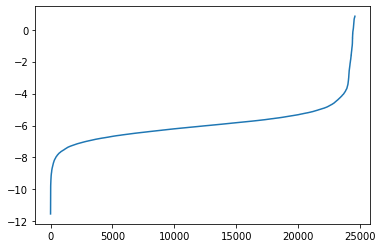

In [5]:
bestdists.sort()
print(len(bestdists))
print(bestdists[23800])
print(len(footprint_frame))
plt.plot(np.log(bestdists[:]))

In [6]:
# calculate distances to houses

NHOUSES = len(footprint_frame)

horiz_x = footprint_frame['centerX'].to_numpy()
horiz_y = footprint_frame['centerY'].to_numpy()
verti_x = np.expand_dims(horiz_x,1)
verti_y = np.expand_dims(horiz_y,1)
dist_matrix = approx_distance(horiz_y,horiz_x, verti_y,verti_x)
dist_matrix

array([[0.        , 0.06429187, 0.29988824, ..., 2.09420734, 0.30049301,
        1.47597209],
       [0.06429187, 0.        , 0.29655395, ..., 2.15818959, 0.35269717,
        1.53003005],
       [0.29988824, 0.29655395, 0.        , ..., 2.19031327, 0.56103034,
        1.37986618],
       ...,
       [2.09420734, 2.15818959, 2.19031327, ..., 0.        , 1.85086228,
        1.33053867],
       [0.30049301, 0.35269717, 0.56103034, ..., 1.85086228, 0.        ,
        1.41539966],
       [1.47597209, 1.53003005, 1.37986618, ..., 1.33053867, 1.41539966,
        0.        ]])

In [7]:
for index,row in footprint_frame.iterrows():
    dists = dist_matrix[index,:]
    dists_sort = np.sort(dists)
    dists0 = dists[dists>0]
    footprint_frame.at[index,'closestHouse'] = dists0.min()
    footprint_frame.at[index,'nClosest'] = dists_sort[:5]

In [8]:
def nobj_to_tuple(x):
    return (x.lon, x.lat)

ignored_road_tags = [
    #'residential',
    'living_street',
    'pedestrian',
    'track', 'raceway',
    'footway',
    'bridleway',
    'steps',
    'corridor',
    'path',
    'cycleway',
    'service'
]

class CounterHandler(osmium.SimpleHandler):
    def __init__(self):
        osmium.SimpleHandler.__init__(self)
        self.num_nodes = 0
        self.nlens = []
        self.segs = []
        self.alltags = {}

    def way(self, n):
        if 'highway' in n.tags and n.tags['highway'] not in ignored_road_tags:
            htag = n.tags['highway']
            self.nlens.append(len(n.nodes))
            self.alltags[htag] = self.alltags.get(htag,0)+1
            num = len(n.nodes)
            for i in range(num-1):
                #dat = (nobj_to_tuple(n.nodes[i]), nobj_to_tuple(n.nodes[i+1]))
                dat = {'x0':n.nodes[i].lon, 'y0':n.nodes[i].lat, 'x1':n.nodes[i+1].lon, 'y1':n.nodes[i+1].lat}
                self.segs.append(dat)
            self.num_nodes += 1

osm_streets = CounterHandler()

osm_streets.apply_file("map.osm", locations=True)

print("Total segments:", len(osm_streets.segs))
print("ways: %d" % osm_streets.num_nodes)
print(osm_streets.alltags)

street_frame = pd.DataFrame(osm_streets.segs)

Total segments: 26582
ways: 2425
{'residential': 1629, 'unclassified': 123, 'motorway_link': 63, 'junction': 6, 'tertiary_link': 1, 'secondary': 267, 'tertiary': 207, 'primary': 65, 'construction': 3, 'motorway': 52, 'road': 2, 'primary_link': 5, 'secondary_link': 2}


In [9]:
# plt.scatter(footprint_frame['centerX'],footprint_frame['centerY'], 1, np.log2(footprint_frame['numAddresses'].clip(0,8)))
# plt.colorbar()

In [10]:
# plt.scatter(footprint_frame['centerX'],footprint_frame['centerY'], 1, np.log2(footprint_frame['ShapeSTArea']))
# plt.colorbar()

In [11]:
# plt.scatter(footprint_frame['centerX'],footprint_frame['centerY'], 1, np.log2(footprint_frame['numAddresses']/footprint_frame['ShapeSTArea']))
# plt.colorbar()

In [12]:
# plt.scatter(footprint_frame['centerX'],footprint_frame['centerY'], 1, np.log2(footprint_frame['closestHouse'].clip(0,.2)))
# plt.colorbar()

In [13]:
print(footprint_frame['Landuse'].unique())
print(footprint_frame['Landuse'].unique().size)
print(len(footprint_frame))

['8 Or More Dwelling Units' 'Condominiums - Owner Occupied'
 'Agriculture (min 10a) - Owner Occupied' 'Single Family - Owner Occupied'
 '3-7 Dwelling Units' 'Single Family - Rental' 'Exempt'
 'Agriculture (min 10a)' 'Duplex - Rental' 'Condominiums - Rental'
 'Mobile Homes' 'Exempt - Miscellaneous Properties'
 'Duplex - Owner Occupied' 'Exempt - Religious Properties'
 '3-7 Dwelling Units - Owner Occupied'
 '8 Or More Dwelling Units - Owner Occupied'
 'Group 1/4s, Fraternities & Sororities'
 '8 Or More Dwelling Units/Commercial' 'Commercial' 'Decorative'
 'Single Family - Duplex' 'School' 'Religious Properties'
 'Communications & Utilities' 'Commercial/Residential'
 'Commercial/Condominiums' nan]
27
21341


In [14]:
house_frame = pd.DataFrame()
house_frame['x'] = footprint_frame['centerX']
house_frame['y'] = footprint_frame['centerY']
house_frame['closestHouse'] = footprint_frame['closestHouse']
house_frame['nClosest'] = footprint_frame['nClosest']
house_frame['logAddresses'] = np.log2(footprint_frame['numAddresses'])
house_frame['logClippedAddresses'] = np.log2(footprint_frame['numAddresses'].clip(0,8))
house_frame['logArea'] = np.log2(footprint_frame['ShapeSTArea'])
house_frame['logDensity'] = np.log2(footprint_frame['numAddresses']/footprint_frame['ShapeSTArea'])
house_frame['logClosest'] = np.log2(footprint_frame['closestHouse'])
house_frame['Terrible'] = house_frame['logClippedAddresses'] - (house_frame['logClippedAddresses']==0)*(house_frame['logClosest']+7.6)
"""house_frame['score'] = 2*house_frame['logClippedAddresses'] \
                     - 2*house_frame['logArea'] \
                     + house_frame['logAddresses'] \
                     - house_frame['logClosest']"""
house_frame['score'] = house_frame['Terrible'] - house_frame['logDensity']
house_frame['Polygon'] = footprint_frame['Polygon']
house_frame

,x,y,closestHouse,nClosest,logAddresses,logClippedAddresses,logArea,logDensity,logClosest,Terrible,score,Polygon
0,-88.247063,40.111913,0.055307,"[0.0, 0.05530655235218846, 0.06298621546409665...",4.247928,3.0,11.532891,-7.284964,-4.176406,3.000000,10.284964,<__main__.FootprintPolygon object at 0x7f3f3e7...
1,-88.246587,40.112362,0.053256,"[0.0, 0.05325568579001909, 0.06429187394240195...",3.321928,3.0,11.432530,-8.110602,-4.230921,3.000000,11.110602,<__main__.FootprintPolygon object at 0x7f3f3e7...
2,-88.249415,40.113922,0.028687,"[0.0, 0.0286872747507856, 0.04307335403611518,...",4.643856,3.0,13.198261,-8.554405,-5.123445,3.000000,11.554405,<__main__.FootprintPolygon object at 0x7f3f3e7...
3,-88.242751,40.120689,0.012376,"[0.0, 0.012375914911182825, 0.0257117996753193...",0.000000,0.0,11.571626,-11.571626,-6.336321,-1.263679,10.307947,<__main__.FootprintPolygon object at 0x7f3f3e7...
4,-88.242813,40.120588,0.012376,"[0.0, 0.012375914911182825, 0.0366368424387522...",2.000000,2.0,11.670952,-9.670952,-6.336321,2.000000,11.670952,<__main__.FootprintPolygon object at 0x7f3f3e7...
...,...,...,...,...,...,...,...,...,...,...,...,...
21336,-88.263367,40.107946,0.017803,"[0.0, 0.01780272678406529, 0.02124491030165729...",0.000000,0.0,11.211492,-11.211492,-5.811758,-1.788242,9.423250,<__main__.FootprintPolygon object at 0x7f3f339...
21337,-88.263392,40.107787,0.016995,"[0.0, 0.01699496201398746, 0.01780272678406529...",0.000000,0.0,11.590126,-11.590126,-5.878749,-1.721251,9.868875,<__main__.FootprintPolygon object at 0x7f3f339...
21338,-88.260588,40.096174,0.025021,"[0.0, 0.025021089760986968, 0.0461818839785538...",0.000000,0.0,7.020223,-7.020223,-5.320712,-2.279288,4.740935,<__main__.FootprintPolygon object at 0x7f3f339...
21339,-88.247055,40.109211,0.017597,"[0.0, 0.01759678719074027, 0.02854269042021032...",3.700440,3.0,12.037703,-8.337263,-5.828544,3.000000,11.337263,<__main__.FootprintPolygon object at 0x7f3f339...


In [15]:
XMIN = house_frame['x'].min()
XMAX = house_frame['x'].max()
YMIN = house_frame['y'].min()
YMAX = house_frame['y'].max()

XSQCENTER = (XMIN+XMAX)/2
YSQCENTER = (YMIN+YMAX)/2

def dilate(pt,center,factor):
    return pt + (pt-center)*factor

DILATE_FACTOR = 1.05

XSTART = dilate(XMIN,XSQCENTER,DILATE_FACTOR)
XEND = dilate(XMAX,XSQCENTER,DILATE_FACTOR)
YSTART = dilate(YMIN,YSQCENTER,DILATE_FACTOR)
YEND = dilate(YMAX,YSQCENTER,DILATE_FACTOR)

X_TOTALLEN = (XEND-XSTART)*DX
Y_TOTALLEN = (YEND-YSTART)*DY
print(X_TOTALLEN,Y_TOTALLEN)

GRIDSQUARE_SIZE = .25 # in km

X_GRIDNUM = int(np.ceil(X_TOTALLEN/GRIDSQUARE_SIZE))
Y_GRIDNUM = int(np.ceil(Y_TOTALLEN/GRIDSQUARE_SIZE))
print(X_GRIDNUM,Y_GRIDNUM)

def convert_to_gridcoord(xy):
    x,y = xy
    xx = int((x-XSTART)*DX/GRIDSQUARE_SIZE)
    yy = int((y-YSTART)*DY/GRIDSQUARE_SIZE)
    return xx,yy

def convert_from_gridcoord(xy):
    x,y = xy
    xx = x*GRIDSQUARE_SIZE/DX+XSTART
    yy = y*GRIDSQUARE_SIZE/DY+YSTART
    return [xx,yy]

def adj_gridcoords(xy):
    x,y = xy
    return (x-1,y), (x,y-1), (x+1,y), (x,y+1)

def grid_components(gridpts):
    used = set()
    ans = []
    for pt in gridpts:
        if pt in used:
            continue
        used.add(pt)
        queue = [pt]
        qcur = 0
        while qcur < len(queue):
            p = queue[qcur]
            qcur += 1
            for q in adj_gridcoords(p):
                if (q in gridpts) and (q not in used):
                    used.add(q)
                    queue.append(q)
        ans.append(queue)
    return ans

def get_borders(gridpts):
    ans = set()
    for pt in gridpts:
        x,y = pt
        if (x-1,y) not in gridpts:
            ans.add(((x,y),'u'))
        if (x,y-1) not in gridpts:
            ans.add(((x,y),'r'))
        if (x+1,y) not in gridpts:
            ans.add(((x+1,y),'u'))
        if (x,y+1) not in gridpts:
            ans.add(((x,y+1),'r'))
    return ans

def segments_around(pt):
    x,y = pt
    ans = ((x,y),'r'), ((x,y),'u'), ((x-1,y),'r'), ((x,y-1),'u')
    return set(ans)

def adj_segments(seg):
    (x,y),d = seg
    ans1 = segments_around((x,y))
    if d == 'u':
        ans2 = segments_around((x,y+1))
    elif d == 'r':
        ans2 = segments_around((x+1,y))
    return ans1.symmetric_difference(ans2)

def signed_area(pts, hasdup=False):
    N = len(pts)
    if hasdup:
        N -= 1
    ans = 0
    for i in range(N):
        j = (i+1)%N
        ans += pts[i][0]*pts[j][1] - pts[i][1]*pts[j][0]
    return ans/2

def group_borders(gridbord):
    used = set()
    ans = []
    maxarea = -1
    outerseg = -1
    for seg_i, seg in enumerate(gridbord):
        if seg in used:
            continue
        used.add(seg)
        seglist = [seg]
        while True:
            found = False
            for s in adj_segments(seg):
                if (s not in used) and (s in gridbord):
                    used.add(s)
                    seglist.append(s)
                    seg = s
                    found = True
                    break
            if not found:
                break
        # check area and reverse if necessary: everything should be clockwise
        sarea = signed_area([ss[0] for ss in seglist])
        if sarea > 0:
            seglist.reverse()
        # check for max area
        area = abs(sarea)
        if area > maxarea:
            maxarea = area
            outerseg = len(ans)
        ans.append(seglist)
    # outer segment should be first in list and counterclockwise
    if outerseg<0 or outerseg>=len(ans):
        print("ZZZ:",ans)
        print(len(ans),outerseg)
    ans[0], ans[outerseg] = ans[outerseg], ans[0]
    ans[0].reverse()
    return [ans[0]] # actually you know what, let's just only include the outer boundary

def segment_endpoints(seg):
    (x,y),d = seg
    if d=='r':
        return set([(x,y),(x+1,y)])
    if d=='u':
        return set([(x,y),(x,y+1)])

def extractelem(st):
    return tuple(st)[0]

def ordered_border_to_polygon(bcomp):
    if len(bcomp)<4:
        print(bcomp)
    startset = segment_endpoints(bcomp[0]) - segment_endpoints(bcomp[1])
    cur = extractelem(startset)
    ans = [convert_from_gridcoord(cur)]
    for seg in bcomp:
        nset = segment_endpoints(seg) - {cur}
        cur = extractelem(nset)
        ans.append(convert_from_gridcoord(cur))
    return ans

def generate_grid_outline(allpts):
    # get grid points
    gridpts = set()
    N = allpts.shape[0]
    for i in range(N):
        newpt = convert_to_gridcoord(tuple(allpts[i,:]))
        gridpts.add(newpt)
    grid_comp = grid_components(gridpts)
    ans = []
    for gp in grid_comp:
        bords = get_borders(gp)
        bord_comps = group_borders(bords)
        polygons = [ordered_border_to_polygon(bcomp) for bcomp in bord_comps]
        ans.append(polygons)
    return ans

generate_grid_outline(np.array([[0,0],[0,.0001]]))

22.484920594632303 28.218313317430354
90 113


[[[[-0.0019073020205837565, 9.217984761988873e-05],
   [0.001032641316101035, 9.217984761988873e-05],
   [0.001032641316101035, 0.0023404632936276926],
   [0.001032641316101035, 0.004588746739635496],
   [-0.0019073020205837565, 0.004588746739635496],
   [-0.0019073020205837565, 0.0023404632936276926],
   [-0.0019073020205837565, 9.217984761988873e-05]]]]

In [16]:

used_segs = {}

def flip_seg(seg):
    seg2 = {}
    seg2['x0'],seg2['y0'],seg2['x1'],seg2['y1'] = seg['x1'],seg['y1'],seg['x0'],seg['y0']
    return seg2

def seg_to_tuple(seg):
    return seg['x0'], seg['y0'], seg['x1'], seg['y1']

def street_intersect(seg):
    fseg = seg_to_tuple(flip_seg(seg))
    if fseg in used_segs:
        return used_segs[fseg]
    
    sf = street_frame
    denom = (seg['x0']-seg['x1'])*(sf['y0']-sf['y1']) - (seg['y0']-seg['y1'])*(sf['x0']-sf['x1'])
    num_t = (seg['x0']-sf['x0'])*(sf['y0']-sf['y1']) - (seg['y0']-sf['y0'])*(sf['x0']-sf['x1'])
    num_u = (seg['x1']-seg['x0'])*(seg['y0']-sf['y0']) - (seg['y1']-seg['y0'])*(seg['x0']-sf['x0'])
    val_t = num_t / denom
    val_u = num_u / denom
    ans = sum((0<=val_t) & (val_t<=1) & (0<=val_u) & (val_u<=1))
    
    used_segs[seg_to_tuple(seg)] = ans
    return ans

class StreetComparisons:
    count = 0

def edgeBinary(index, row):
    dist = dist_matrix[index,:]
    #mindist = np.partition(dist,1)[1]
    mindist = row['nClosest'][2]
    maxdist = min(0.1, mindist*2)
    maxdist = row['nClosest'][4]
    #scoreDiff = np.abs(row['score']-house_frame['score'])
    #return (dist < maxdist) & (scoreDiff < 2)
    cands = dist < maxdist
    adjs = np.where(cands)[0]
    for adj in adjs:
        # check if house_frame.at[index,_]--house_frame.at[adj,_] intersects with any road
        seg = {
            'x0': house_frame.at[index,'x'], 'y0': house_frame.at[index,'y'],
            'x1': house_frame.at[adj,'x'], 'y1': house_frame.at[adj,'y']
        }
        has_intersect = street_intersect(seg)
        StreetComparisons.count += 1
        # change cands[adj] to 0 if necessary
        if has_intersect > 0:
            cands[adj] = 0
    return cands

NODES = len(house_frame)

adjList = [None]*NODES
prog = progress.Progress(len(house_frame),1000)
for index, row in house_frame.iterrows():
    prog.update()
    adjList[index] = np.where(edgeBinary(index, row))[0]

print('street comparisons:',StreetComparisons.count)

START (21341 total, updates every 1000)
1000 / 21341 = 0.047 (9.91 s)
2000 / 21341 = 0.094 (21.08 s)
3000 / 21341 = 0.141 (31.07 s)
4000 / 21341 = 0.187 (41.21 s)
5000 / 21341 = 0.234 (53.51 s)
6000 / 21341 = 0.281 (65.26 s)
7000 / 21341 = 0.328 (75.08 s)
8000 / 21341 = 0.375 (86.12 s)
9000 / 21341 = 0.422 (96.87 s)
10000 / 21341 = 0.469 (107.14 s)
11000 / 21341 = 0.515 (117.14 s)
12000 / 21341 = 0.562 (127.34 s)
13000 / 21341 = 0.609 (138.90 s)
14000 / 21341 = 0.656 (149.11 s)
15000 / 21341 = 0.703 (158.63 s)
16000 / 21341 = 0.750 (168.19 s)
17000 / 21341 = 0.797 (177.95 s)
18000 / 21341 = 0.843 (188.20 s)
19000 / 21341 = 0.890 (199.07 s)
20000 / 21341 = 0.937 (209.78 s)
21000 / 21341 = 0.984 (219.04 s)
21341 / 21341 = 1.000 (221.98 s)
street comparisons: 85364


In [17]:
def generate_convex_hull(allpts):
    N = allpts.shape[0]
    if N > 2:
        hull = list(scipy.spatial.ConvexHull(allpts).vertices)
        hull.append(hull[0])
        hullpts = allpts[hull,:]
        return hullpts
    else:
        return allpts

components = []
hulls = []
outlines = []
vis = np.zeros(NODES)
for start in range(NODES):
    if vis[start]:
        continue
    vis[start] = 1
    queue = [start]
    qcur = 0
    while qcur < len(queue):
        elem = queue[qcur]
        qcur += 1
        for nei in adjList[elem]:
            if vis[nei]:
                continue
            vis[nei] = 1
            queue.append(nei)
    allpts = np.zeros((qcur, 2))
    for i,ind in enumerate(queue):
        allpts[i,0] = house_frame.at[ind,'x']
        allpts[i,1] = house_frame.at[ind,'y']
    components.append(allpts)
    hulls.append(generate_convex_hull(allpts))
    outlines.append(generate_grid_outline(allpts))

components = [c.tolist() for c in components]
hulls = [c.tolist() for c in hulls]

In [18]:
def dump_const(file,name,value):
    file.write('const %s = ' % name)
    json.dump(value, file, indent=2)
    file.write(';\n')

outfile = open('convex_hulls.js','w')
dump_const(outfile, 'hulls', hulls)
dump_const(outfile, 'components', components)
dump_const(outfile, 'outlines', outlines)
outfile.close()